Epoch 1/500
3/3 [==============================] - 6s 346ms/step - loss: 13.7691 - val_loss: 0.2744 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - 0s 77ms/step - loss: 9.0526 - val_loss: 0.1380 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - 0s 73ms/step - loss: 7.9508 - val_loss: 0.1437 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - 0s 36ms/step - loss: 6.6748 - val_loss: 0.1468 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - 0s 42ms/step - loss: 5.6030 - val_loss: 0.1352 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - 0s 37ms/step - loss: 4.8157 - val_loss: 0.1554 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - 0s 43ms/step - loss: 4.6616 - val_loss: 0.2005 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - 0s 40ms/step - loss: 3.9607 - val_loss: 0.2087 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - 0s 47ms/step - loss: 4.0078 - val_loss: 0.1729 - lr: 0.0010

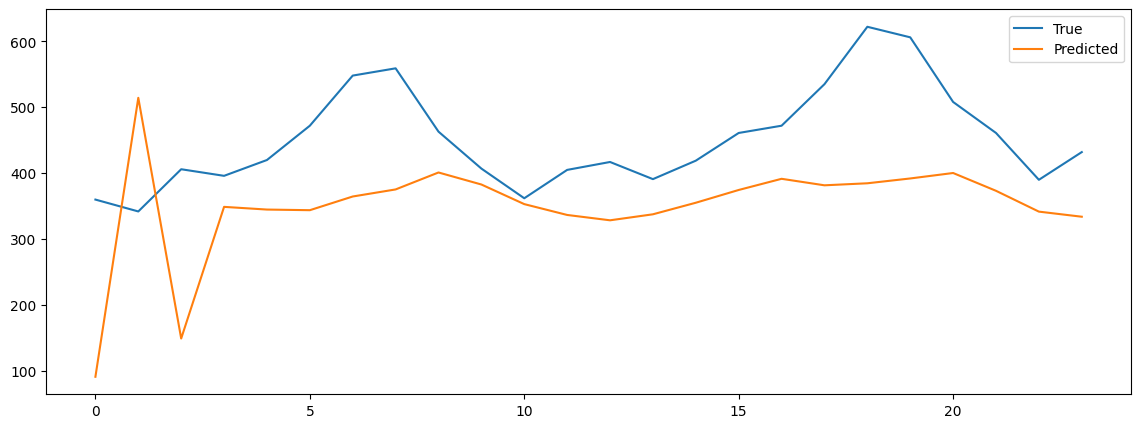

Mean Squared Error on Test Set: 18917.623046875


In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 设置随机种子
np.random.seed(42)
tf.random.set_seed(42)

# 载入数据集
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, header=0, index_col=0)
series = data.values.flatten()

# 数据预处理 - 使用 MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series.reshape(-1, 1)).flatten()

# 生成时间序列数据
def create_dataset(series, time_steps):
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i:i + time_steps])
        y.append(series[i + time_steps])
    return np.array(X), np.array(y)

# 定义时间步长
time_steps = 24  # 增加时间跨度

# 创建数据集
X, y = create_dataset(series, time_steps)
X = X[:, :, np.newaxis]

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 构建TCN模型
def build_tcn_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    # 第一个卷积层
    x = layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    res = x

    for _ in range(5):  # 增加卷积层数量
        x = layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, res])  # 引入残差连接
        res = x

    outputs = layers.Conv1D(filters=1, kernel_size=1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss=keras.losses.MeanSquaredError())
    return model

# 获取输入形状
input_shape = (X_train.shape[1], X_train.shape[2])

# 创建模型
model = build_tcn_model(input_shape)

# 训练模型
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=1, callbacks=[early_stop, reduce_lr])

# 进行预测
y_pred = model.predict(X_test).flatten()

# 反标准化
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 修正预测结果形状
trimmed_y_pred = y_pred[:len(y_test)]

# 绘制预测结果
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='True')
plt.plot(trimmed_y_pred, label='Predicted')
plt.legend()
plt.show()

# 计算模型评估指标
mse = keras.losses.MeanSquaredError()(y_test, trimmed_y_pred).numpy()
print(f"Mean Squared Error on Test Set: {mse}")